## Scene Classification: CNN_2D, CNN_1D

### A. Problem Motivation: 

???

### B.  Dataset Description

Dataset: https://www.kaggle.com/datasets/nitishabharathi/scene-classification?resource=download&select=train-scene+classification

This dataset contains about ~25k images from a wide range of natural scenes from all around the world. The task is to identify which kind of scene can the image be categorized into.

It is a 6 class problem

 1. Buildings
 2. Forests
 3. Mountains
 4. Glacier
 5. Street
 6. Sea


### C. Solution/ Approach Description
#### C1.  Imports

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

#### C2. Configurations, Data Load, Global Variables

In [2]:
# Added GPU configs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

# File read
img_path = "./train_scene_classification/train/"             # get image file path
df = pd.read_csv("./train_scene_classification/train.csv")   # read label csv

# Assign names to label_ids: 0-5
# The labels have been rearranged from their order in kaggle to how they correspond to images in train.csv 
label_name = ['buildings','forests','glacier','mountains','sea','street']


#### C3.  Exploratory Analysis
##### c3.1 Variable counts

In [3]:
class_count = len(label_name)                                # class count: refer to Kaggle class descriptions
img_count = len(os.listdir(img_path))                        # number of images in img_path
lbl_count = len(df)                                          # number of labels in train.csv 

print("Check var_counts:")
print("  class_count:", class_count)
print("  img_count:", img_count)
print("  lbl_count:", lbl_count)

Check var_counts:
  class_count: 6
  img_count: 24335
  lbl_count: 17034


##### c3.2 Image selection and sampling

There are 55 images are of shape (150,150,3).  There are two ways to remedy this-- we can omit the non-conforming images from our final sampling, or make all images uniform in shape via padding (i.e., set ***pad_img_var*** below to **True**).  Since not all images have labels (see img_count and lbl_count discrepancy above) and only a sample will be drawn from the labels to make the final training/validation/testing sets anyway, then setting **pad_img_arr** to **False** (i.e., omit non-conforming images) seems the more practical approach.

In [4]:
# Sort by Label Classification
img_sorted = [0] * class_count
img_sorted = [[] for i in range(class_count)]

img_tmp = []
lbl_tmp = []

non_conform_count = 0
conform_count = 0

pad_img_arr = False

for i in range(lbl_count): 
    j = df.label[i]
    k = df.image_name[i]
    
    img = load_img(img_path+k)
    
    m = img_to_array(img)
    
    if m.shape != (150,150,3):
        non_conform_count += 1
        
        if pad_img_arr:
            m = np.pad(m,[(0,150 - m.shape[0]),(0,0),(0,0)])
        else:
            continue
    
    conform_count += 1
    
    img_sorted[j].append(img)
    img_tmp.append(m)
    lbl_tmp.append(j)

print("No. of images of shape (150,150,3):",conform_count)
print("No. of images not of shape (150,150,3):",non_conform_count)
print(f"Compare total images with labels to lbl_count var: {conform_count + non_conform_count} vs. {lbl_count}")

No. of images of shape (150,150,3): 16979
No. of images not of shape (150,150,3): 55
Compare total images with labels to lbl_count var: 17034 vs. 17034


##### c3.3 Generate an equal number of random samples from each class

IDs of the samples per label: [550, 2331, 258, 1044, 482]
BUILDINGS:


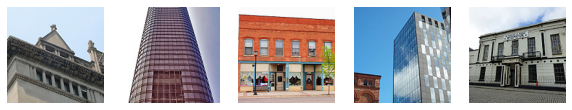

IDs of the samples per label: [800, 1773, 303, 1134, 840]
FORESTS:


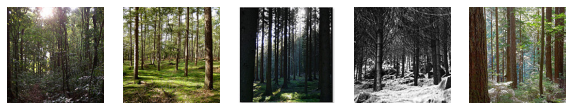

IDs of the samples per label: [290, 871, 1396, 879, 1212]
GLACIER:


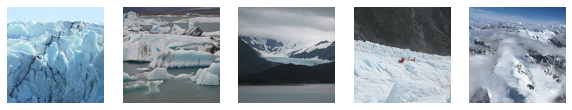

IDs of the samples per label: [1692, 2911, 598, 1912, 651]
MOUNTAINS:


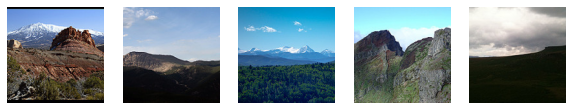

IDs of the samples per label: [949, 1332, 2660, 2597, 755]
SEA:


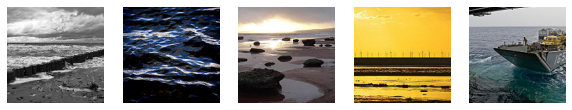

IDs of the samples per label: [1010, 983, 1793, 969, 245]
STREET:


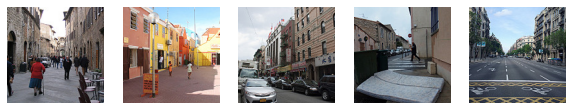

In [5]:
# number of images from each class to be included in the training, validation and testing sets
samp_count = 2500

# number of sample images to be previewed 
sub_samp = 5

samp = [0] * class_count
samp = [[] for i in range(class_count)]

img_arr = []
lbl_arr = []
gra_arr = []

def plot_sample_images(img,label=None,show_enum=False):
    tmp = []
    
    fig = plt.figure(figsize=(10,20))
    gs = fig.add_gridspec(1,sub_samp)

    ax = [fig.add_subplot(gs[0,i]) for i in range(sub_samp)]
    
    for j in range(sub_samp):
        
        tmp.append('      ['+str(j+1)+']     ')
        
        ax[j].imshow(img[j])
        ax[j].axis('off')
        
        if label != None:
            if type(label) == list:
                ax[j].set_title(label_name[label[j]])
            else:
                ax[j].set_title(label)
        
    if show_enum:
        print(*tmp)
                
    plt.show()

random.seed(1)

for i in range(class_count):
    r = random.sample(range(0, len(img_sorted[i])), samp_count)
    
    for j in range(samp_count):
        m = img_tmp[r[j]]
        
        img_arr.append(m)
        lbl_arr.append(lbl_tmp[r[j]])
        gra_arr.append(tf.image.rgb_to_grayscale(m))

    for j in range(sub_samp):
        m = img_sorted[i][r[j]]
        
        samp[i].append(m)
        
    print(f'IDs of the samples per label: {r[:sub_samp]}\n{label_name[i].upper()}:')
    plot_sample_images(samp[i],None,False)
    

##### c3.4 Show original and grayscale images 

ORIGINAL ORDER (First 5 images+labels from the original list):


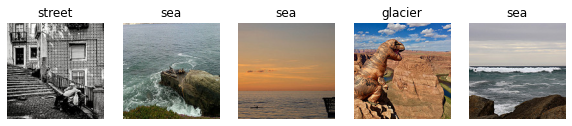


ORIGINAL ORDER - IN GRAYSCALE


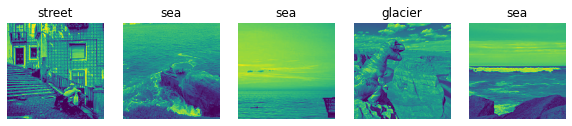

In [6]:
def show_sample_images(img,label=None,show_enum=True):
    t = []
    
    [t.append(array_to_img(img[i])) for i in range(sub_samp)]
    
    plot_sample_images(t,label,show_enum)

print("ORIGINAL ORDER (First 5 images+labels from the original list):")
show_sample_images(img_arr,list(lbl_arr[:5]),False)

print("\nORIGINAL ORDER - IN GRAYSCALE")
show_sample_images(gra_arr,list(lbl_arr[:5]),False)


#### C4.  Data Preprocessing

##### c4.1 Cast original and grayscale images and labels to numpy arrays

In [7]:
img_arr = np.array(img_arr)
gra_arr = np.array(gra_arr)
lbl_arr = np.array(lbl_arr)

# Validate: image and label shapes
print(f'original images  : shape: {img_arr.shape}, type: {type(img_arr)}')
print(f'grayscale images : shape: {gra_arr.shape}, type: {type(gra_arr)}')
print(f'image labels     : shape: {lbl_arr.shape}, type: {type(lbl_arr)}')

original images  : shape: (15000, 150, 150, 3), type: <class 'numpy.ndarray'>
grayscale images : shape: (15000, 150, 150, 1), type: <class 'numpy.ndarray'>
image labels     : shape: (15000,), type: <class 'numpy.ndarray'>


##### c4.2 Split data to training, validation and test; shuffle data

In [8]:
def split_and_shuffle(images,labels,split=(0.6,0.2,0.2)):  
    """ Split data into train, validation and test sets; shuffle the data"""
    
    # Create train/validation/test sets 
    
    tf.random.set_seed(1)
    np.random.seed(1)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, labels = images[shuffle], labels[shuffle]
    
    splits = np.multiply(len(images), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(labels, [splits[0], splits[0]+splits[1]])
    
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    # Shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() # also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

### D. Experiment_1: Convolutional Neural Network- 2D/RGB

#### D1. Apply CNN_2D Preprocessing and Validate Shapes

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_and_shuffle(
    images=img_arr,
    labels=lbl_arr,
    split=(0.6,0.2,0.2))

X_train_2d = X_train
y_train_2d = y_train

print("Validate shape:")
print(f"  X_train shape {X_train.shape}")
print(f"  y_train shape {y_train.shape}")
print(f"  X_val shape {X_val.shape}")
print(f"  y_val shape {y_val.shape}")
print(f"  X_test shape {X_test.shape}")
print(f"  y_test shape {y_test.shape}")

print(f"\nTotal: {X_train.shape[0]+X_val.shape[0]+X_test.shape[0]} of {class_count*samp_count}")

Validate shape:
  X_train shape (9000, 150, 150, 3)
  y_train shape (9000,)
  X_val shape (3000, 150, 150, 3)
  y_val shape (3000,)
  X_test shape (3000, 150, 150, 3)
  y_test shape (3000,)

Total: 15000 of 15000


#### D2. CNN_2D Model Build

In [10]:
cnn_2d = tf.keras.Sequential()

# first convolution layer
cnn_2d.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

# max pooling layer with pool size (2,2), strides of 2
cnn_2d.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_1'))

# second convolutional layer
cnn_2d.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
cnn_2d.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), 
    name='pool_2'))

# add a fully connected layer (need to flatten the output of the previous layers first)
cnn_2d.add(tf.keras.layers.Flatten()) 
cnn_2d.add(tf.keras.layers.Dense(
    units=64,
    name='fc_1', 
    activation='relu'))

# add dropout layer
cnn_2d.add(tf.keras.layers.Dropout(rate=0.5))

cnn_2d.add(tf.keras.layers.Dense(
    units=10,
    name='fc_2',
    activation='softmax'))

# build model and print summary
tf.random.set_seed(1)
cnn_2d.build(input_shape=X_train.shape)
cnn_2d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (9000, 150, 150, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (9000, 75, 75, 32)        0         
                                                                 
 conv_2 (Conv2D)             (9000, 75, 75, 64)        18496     
                                                                 
 pool_2 (MaxPooling2D)       (9000, 37, 37, 64)        0         
                                                                 
 flatten (Flatten)           (9000, 87616)             0         
                                                                 
 fc_1 (Dense)                (9000, 64)                5607488   
                                                                 
 dropout (Dropout)           (9000, 64)                0

#### D3. CNN_2D Model Compile and Train

In [11]:
cnn_2d.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

history_2d = cnn_2d.fit(X_train,
                        y_train,
                        epochs=5,
                        validation_data=(X_val, y_val),
                        verbose=1)

Epoch 1/5
282/282 [==============================] - 122s 430ms/step - loss: 1.2050 - accuracy: 0.5431 - val_loss: 0.6598 - val_accuracy: 0.7570
Epoch 2/5
282/282 [==============================] - 113s 401ms/step - loss: 0.6900 - accuracy: 0.7424 - val_loss: 0.3412 - val_accuracy: 0.8997
Epoch 3/5
282/282 [==============================] - 93s 331ms/step - loss: 0.4280 - accuracy: 0.8414 - val_loss: 0.1729 - val_accuracy: 0.9603
Epoch 4/5
282/282 [==============================] - 169s 601ms/step - loss: 0.2777 - accuracy: 0.8938 - val_loss: 0.1566 - val_accuracy: 0.9620
Epoch 5/5
282/282 [==============================] - 170s 604ms/step - loss: 0.2035 - accuracy: 0.9247 - val_loss: 0.0711 - val_accuracy: 0.9867


#### D4. Plot CNN_2D Model History

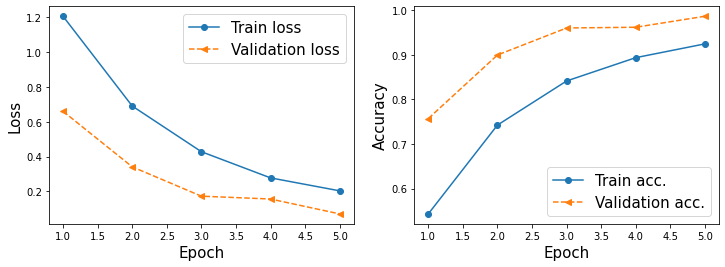

In [12]:
def plot_history(hist):
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

plot_history(history_2d.history)

#### D5. Evaluate the CNN_2D Model vs. Test Data

In [13]:
cnn_2d.evaluate(X_test,y_test)

94/94 [==============================] - 7s 70ms/step - loss: 0.0637 - accuracy: 0.9897


[0.06367163360118866, 0.9896666407585144]

#### D6. CNN_2D Model Predict

CNN_2D Predict:
94/94 [==============================] - 8s 82ms/step

The list below are from 5 contiguous images/labels starting from random id_no. 2478
Actual labels vs. images


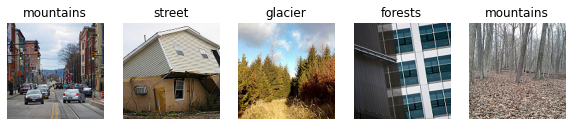

Predicted labels vs. images


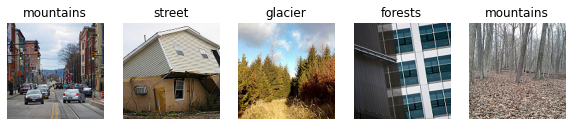

In [14]:
samp = 5

# Get a random starting point
r = random.randint(0, samp_count - samp)

# Derive the predicted values of X_test
print("CNN_2D Predict:")
y = cnn_2d.predict(X_test)
y_pred = [np.argmax(i) for i in y]

print(f"\nThe list below are from 5 contiguous images/labels starting from random id_no. {r}")
print("Actual labels vs. images")
plot_sample_images(X_train[r:r+samp],list(y_pred[r:r+samp]),False)

print("Predicted labels vs. images")
plot_sample_images(X_train[r:r+samp],list(y_test[r:r+samp]),False)


#### D7. Generate classification report

In [15]:
from sklearn.metrics import classification_report

print("Classification Report: \n\n",classification_report(y_test,y_pred))

Classification Report: 

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       431
           1       1.00      0.99      1.00       451
           2       0.98      0.98      0.98       491
           3       0.99      0.98      0.98       530
           4       0.99      0.99      0.99       459
           5       0.99      1.00      1.00       638

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



<b><u>Classification Report Labels:</u></b>

&nbsp;&nbsp;&nbsp;&nbsp;<b>Precision :</b> Percentage of correct positive predictions relative to total positive predictions.<br>
&nbsp;&nbsp;&nbsp;&nbsp;<b>Recall &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:</b> Percentage of correct positive predictions relative to total actual positives.<br>
&nbsp;&nbsp;&nbsp;&nbsp;<b>F1-Score &nbsp;:</b> A weighted harmonic mean of precision and recall. <b><u>The closer to 1, the better the model.</u></b>
<blockquote><b><i>F1-Score: 2 * (Precision * Recall) / (Precision + Recall)</i></b></blockquote>

&nbsp;&nbsp;&nbsp;&nbsp;<b>Support:</b> These values tell us how many images belong to each class in the test dataset. 

#### D8. Comments

From *CNN_2D.evaluate(), model.predict() and the classification report*, we see that CNN_2D yielded high accuracy scores (> 0.90) on all data sets. Thus, this is an excellent classification model for our images, even without applying augmentation.  Nonetheless, we will continue to experiment on other approaches below. 
    

### E. Experiment_2: Convolutional Neural Network- 1D/Grayscale
#### E1. Apply CNN_1D Preprocessing and Validate Shapes

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_and_shuffle(
    images=gra_arr,
    labels=lbl_arr,
    split=(0.6,0.2,0.2))

X_train_1d = X_train
y_train_1d = y_train

print("Validate shape")
print(f"  X_train shape {X_train.shape}")
print(f"  y_train shape {y_train.shape}")
print(f"  X_val shape {X_val.shape}")
print(f"  y_val shape {y_val.shape}")
print(f"  X_test shape {X_test.shape}")
print(f"  y_test shape {y_test.shape}")

print(f"\nTotal: {X_train.shape[0]+X_val.shape[0]+X_test.shape[0]} of {class_count*samp_count}")

Validate shape
  X_train shape (9000, 150, 150, 1)
  y_train shape (9000,)
  X_val shape (3000, 150, 150, 1)
  y_val shape (3000,)
  X_test shape (3000, 150, 150, 1)
  y_test shape (3000,)

Total: 15000 of 15000


#### E2. CNN_1D Model Build 

In [18]:
cnn_1d = tf.keras.Sequential()

cnn_1d.add(tf.keras.layers.Conv1D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))

cnn_1d.add(tf.keras.layers.MaxPool1D(
    pool_size=2,
    name='pool_1'))

cnn_1d.add(tf.keras.layers.Conv1D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    data_format='channels_last',
    name='conv_2',
    activation='relu'))

cnn_1d.add(tf.keras.layers.MaxPool1D(
    pool_size=2,
    name='pool_2'))

cnn_1d.add(tf.keras.layers.Flatten()) 
cnn_1d.add(tf.keras.layers.Dense(
    units=64,
    name='fc_1',
    activation='relu'))

cnn_1d.add(tf.keras.layers.Dropout(rate=0.5))

cnn_1d.add(tf.keras.layers.Flatten()) 
cnn_1d.add(tf.keras.layers.Dense(
    units=10,
    name='fc_2',
    activation='softmax'))


tf.random.set_seed(1)
cnn_1d.build(input_shape=(None,150,150))
cnn_1d.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 150, 32)           14432     
                                                                 
 pool_1 (MaxPooling1D)       (None, 75, 32)            0         
                                                                 
 conv_2 (Conv1D)             (None, 75, 64)            6208      
                                                                 
 pool_2 (MaxPooling1D)       (None, 37, 64)            0         
                                                                 
 flatten_3 (Flatten)         (None, 2368)              0         
                                                                 
 fc_1 (Dense)                (None, 64)                151616    
                                                                 
 dropout_2 (Dropout)         (None, 64)               

#### E3. CNN_1D Model Compile and Train 

In [19]:
cnn_1d.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               metrics=['accuracy'])

history_1d = cnn_1d.fit(X_train, 
                        y_train,
                        epochs=30, 
                        validation_data=(X_val, y_val),
                        verbose=1)

Epoch 1/30
282/282 [==============================] - 3s 8ms/step - loss: 1.5906 - accuracy: 0.3686 - val_loss: 1.2549 - val_accuracy: 0.5230
Epoch 2/30
282/282 [==============================] - 2s 8ms/step - loss: 1.3385 - accuracy: 0.4784 - val_loss: 1.1853 - val_accuracy: 0.5440
Epoch 3/30
282/282 [==============================] - 2s 8ms/step - loss: 1.2831 - accuracy: 0.5046 - val_loss: 1.2984 - val_accuracy: 0.4837
Epoch 4/30
282/282 [==============================] - 2s 8ms/step - loss: 1.1950 - accuracy: 0.5371 - val_loss: 1.1650 - val_accuracy: 0.5713
Epoch 5/30
282/282 [==============================] - 2s 8ms/step - loss: 1.1502 - accuracy: 0.5534 - val_loss: 1.0469 - val_accuracy: 0.6003
Epoch 6/30
282/282 [==============================] - 2s 7ms/step - loss: 1.1220 - accuracy: 0.5629 - val_loss: 0.9554 - val_accuracy: 0.6473
Epoch 7/30
282/282 [==============================] - 2s 7ms/step - loss: 1.0079 - accuracy: 0.6064 - val_loss: 1.0053 - val_accuracy: 0.6170
Epoch 

#### E4. Plot CNN_1D Model History

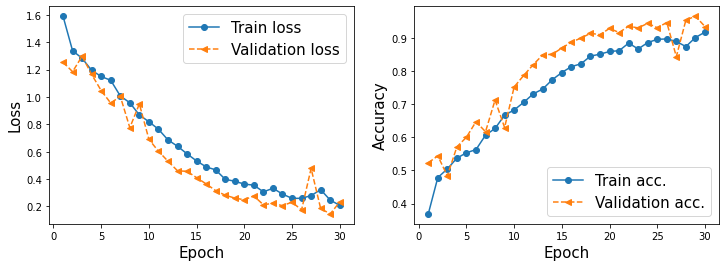

In [20]:
plot_history(history_1d.history)

#### E5. Evaluate the CNN_1D Model vs. Test Data

In [21]:
cnn_1d.evaluate(X_test,y_test)

94/94 [==============================] - 0s 2ms/step - loss: 0.2420 - accuracy: 0.9397


[0.24203546345233917, 0.9396666884422302]

#### E6. CNN_1D Model Predict

CNN_1D Predict:
94/94 [==============================] - 0s 2ms/step

The list below are from 5 contiguous images/labels starting from random id_no. 1361
Actual labels vs. images


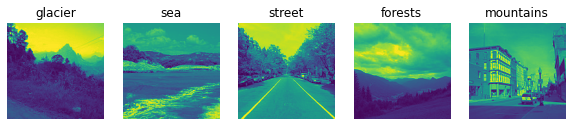

Predicted labels vs. images


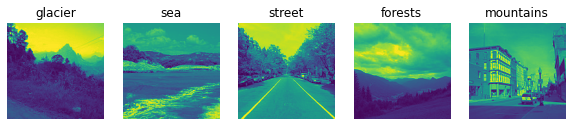

In [22]:
# Get a random starting point
r = random.randint(0, samp_count - samp)

# Derive the predicted values of X_test
print("CNN_1D Predict:")
y = cnn_1d.predict(X_test)
y_pred = [np.argmax(i) for i in y]

print(f"\nThe list below are from 5 contiguous images/labels starting from random id_no. {r}")
print("Actual labels vs. images")
plot_sample_images(X_train[r:r+samp],list(y_pred[r:r+samp]),False)

print("Predicted labels vs. images")
plot_sample_images(X_train[r:r+samp],list(y_test[r:r+samp]),False)


#### E7. Generate classification report

In [23]:
print("Classification Report: \n\n",classification_report(y_test,y_pred))

Classification Report: 

               precision    recall  f1-score   support

           0       0.97      0.94      0.95       431
           1       0.85      0.99      0.91       451
           2       0.98      0.89      0.93       491
           3       0.92      0.95      0.94       530
           4       0.94      0.89      0.92       459
           5       0.98      0.97      0.98       638

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



#### E8. Comments

CNN_1D is equally reliable in modelling our image classes.  Although this requires more epochs to approximate the accuracy level of CNN_2D, CNN_1D has a much faster compute rate than CNN_2D's 5 epochs.

### F. Additional Tests:  Show Learning Pattern per Layer

In [24]:
# Select a sample image to visualize

def get_image_tensor(X_train,y_train):
    img_tensor = np.expand_dims(X_train[2], axis = 0);

    # Print image tensor shape
    print('Shape of image:', img_tensor.shape);
  
    # Display the sample image
    plt.imshow(img_tensor[0]);
    plt.title('label:' + str(y_train[1]))
    #plt.axis('off')
    plt.show()
    
    return img_tensor

In [25]:
# outputs of the first 4 layers, which include conv2D and max pooling layers

def display_learning_pattern(model,img_tensor):
    layer_outputs = [layer.output for layer in model.layers[:4]]
    activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(img_tensor)

    # grab layer names
    layer_names = []
    for layer in model.layers[:4]:
        layer_names.append(layer.name)

    # getting activations of each layer
    for idx, layer in enumerate(activations):
        if idx in (0,1,2,3):
            print('----------------')
            print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
            activation = layer

            # shape of layer activation
            print('Images size is', activation.shape[3], 'x', activation.shape[2])
            print('Number of channels is', activation.shape[1])

            # print channels
            print('Printing channels:')

            # define nrows and ncols depending on number of channels
            if idx in (0,1):
                nrows, ncols = 4,8
            if idx in (2,3):
                nrows, ncols = 8,8

            # plots
            channel=0
            if idx in (0,1):
                f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
            if idx in (2,3):
                f, axs = plt.subplots(nrows, ncols, figsize=(14,20))

            for i in range(nrows):
                for j in range(ncols):
                    if i==0 and j==0:
                        channel=0
                    else:
                        channel+=1

                    axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                    axs[i,j].set(title=str(channel))
                    #axs[i,j].axis('off') # pay attention to the range of x and y axis
            plt.show()

Shape of image: (1, 150, 150, 3)


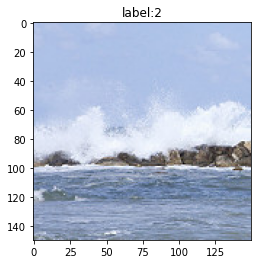

1/1 [==============================] - 0s 50ms/step
----------------
Geeting activations of layer 1 : conv_1
Images size is 32 x 150
Number of channels is 150
Printing channels:


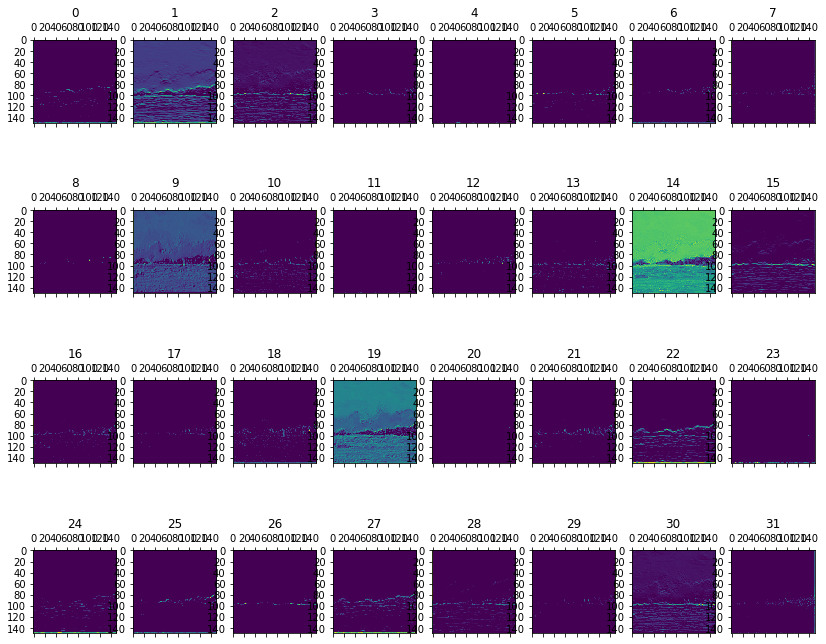

----------------
Geeting activations of layer 2 : pool_1
Images size is 32 x 75
Number of channels is 75
Printing channels:


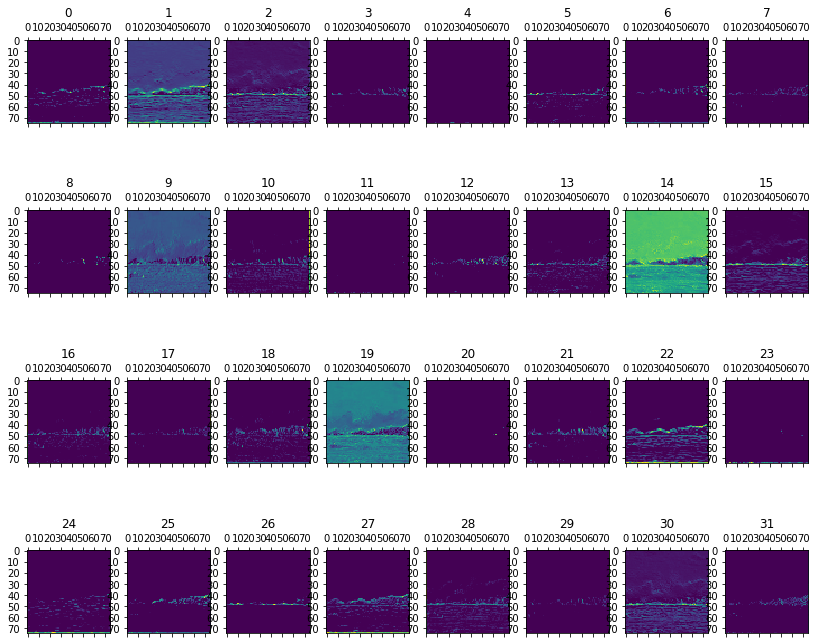

----------------
Geeting activations of layer 3 : conv_2
Images size is 64 x 75
Number of channels is 75
Printing channels:


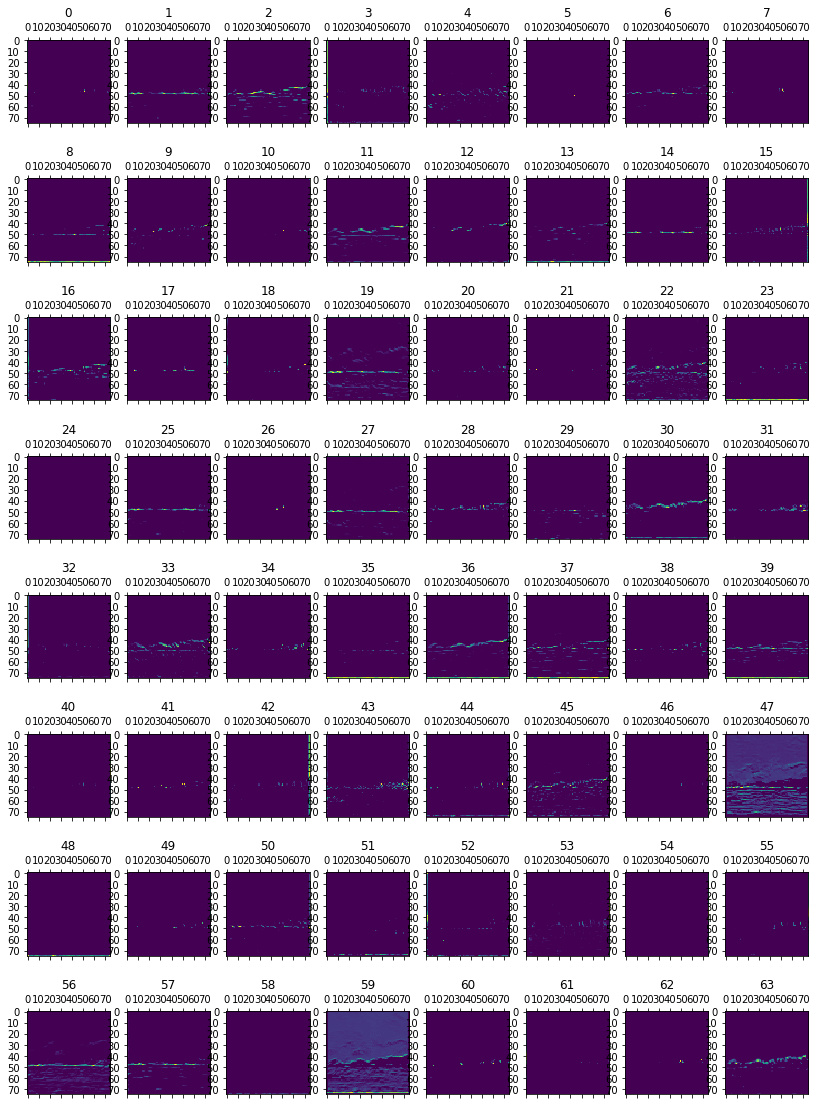

----------------
Geeting activations of layer 4 : pool_2
Images size is 64 x 37
Number of channels is 37
Printing channels:


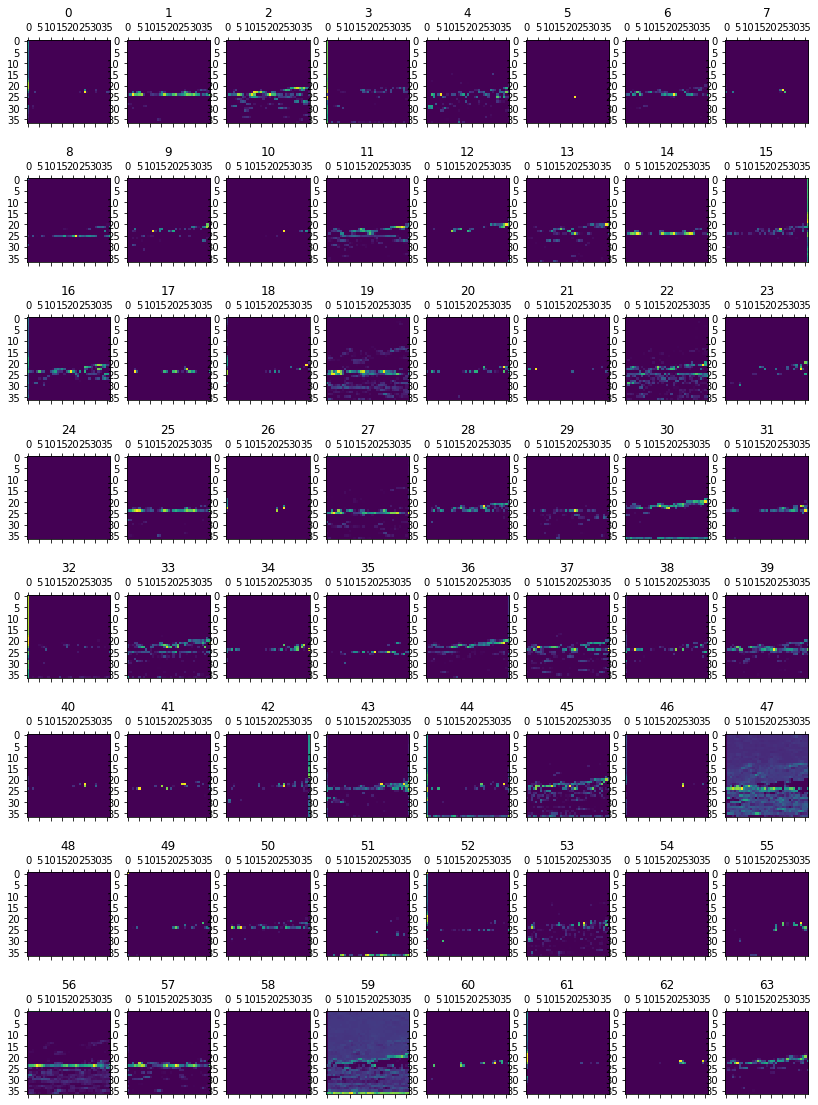

In [26]:
img_tensor = get_image_tensor(X_train_2d,y_train_2d)
display_learning_pattern(cnn_2d,img_tensor)